In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
# data = data.merge(GDPQ, on=['year', 'month'], how='left')
print(data.columns)
# data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
print(data.isnull().sum())




[*********************100%***********************]  1 of 1 completed

Index(['date_x', 'close', 'volume', 'high', 'low', 'pe',
       'num_daily_adv_minus_decl', 'mov_avg_20d', 'best_eps', 'dvd_sh_last',
       'rsi_3d', 'rsi_9d', 'rsi_14d', 'rsi_30d', 'mov_avg_10d', 'mov_avg_30d',
       'mov_avg_50d', 'pb', 'pib_pct', 'pib', 'vix', 'i', 'i_future',
       'inflation', 'gold', 'gold_pct', 'gold_volume', 'brent', 'brent_pct',
       'brent_volume', 'cible', 'returns', 'vol', 'score', 'momentum_10d',
       'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'mov_avg_100d',
       'mov_avg_200d', 'mov_avg_10_50_diff', 'mov_avg_20_50_diff',
       'close_minus_10d', 'close_minus_20d', 'close_minus_30d',
       'close_minus_50d', 'close_minus_100d', 'close_minus_200d', 'DXY',
       'year', 'month', 'timestamp', 'EIA/GDPQXUS/USA', 'date_y'],
      dtype='object')
date_x                      0
close                       0
volume                      0
high                        0
low                         0
pe                          0
num_daily_adv_minus_de

1. Création des variables techniques...
Variables créées. Nouvelles dimensions: (6719, 60)
Variables exogènes sélectionnées (55):
 1. close
 2. volume
 3. high
 4. low
 5. pe
 6. num_daily_adv_minus_decl
 7. mov_avg_20d
 8. best_eps
 9. dvd_sh_last
10. rsi_3d
11. rsi_9d
12. rsi_14d
13. rsi_30d
14. mov_avg_10d
15. mov_avg_30d
16. mov_avg_50d
17. pb
18. pib_pct
19. pib
20. vix
21. i
22. i_future
23. inflation
24. gold
25. gold_pct
26. gold_volume
27. brent
28. brent_pct
29. brent_volume
30. vol
31. score
32. momentum_10d
33. macd
34. macd_signal
35. bb_upper
36. bb_lower
37. mov_avg_100d
38. mov_avg_200d
39. mov_avg_10_50_diff
40. mov_avg_20_50_diff
41. close_minus_10d
42. close_minus_20d
43. close_minus_30d
44. close_minus_50d
45. close_minus_100d
46. close_minus_200d
47. DXY
48. EIA/GDPQXUS/USA
49. volatility_5d
50. volatility_20d
51. ma_signal_short
52. ma_signal_long
53. volume_ma_20
54. volume_ratio
55. high_volume

Corrélations avec les rendements:
   ma_signal_short: 0.297
   ma_s

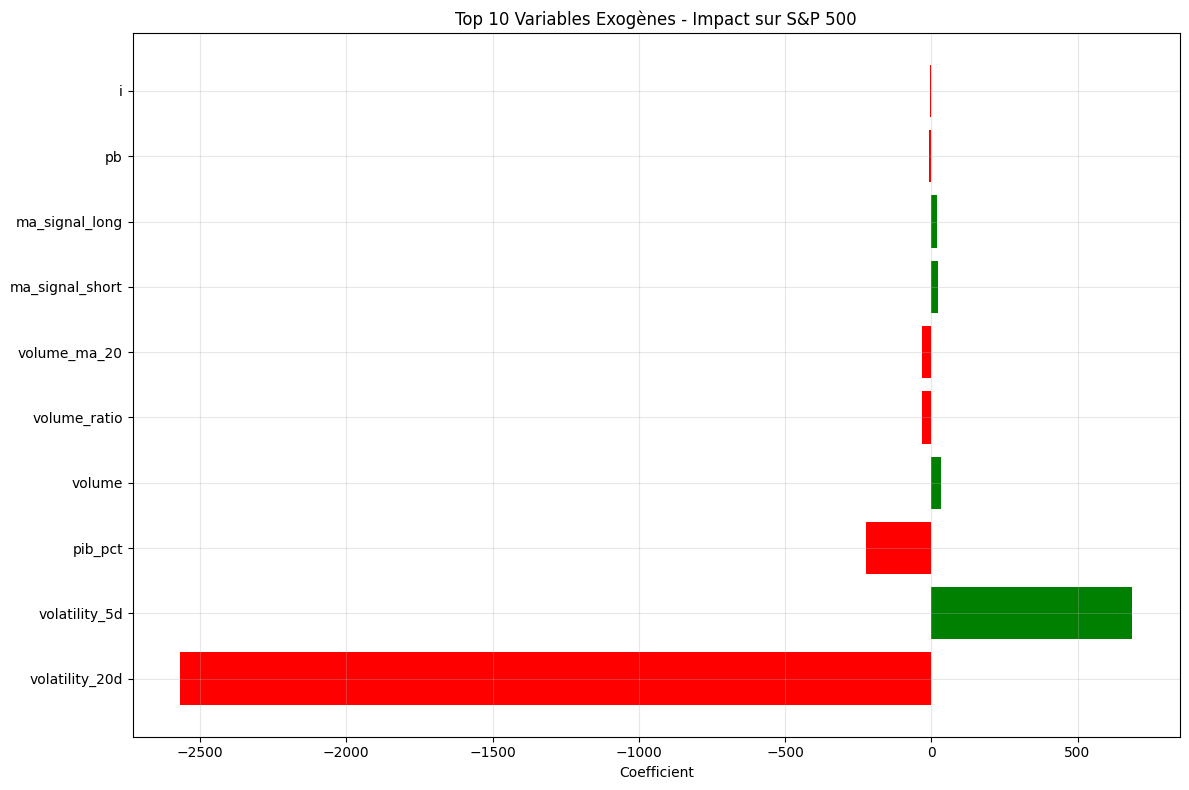

exog_params: close                       7.153424e-02
volume                      3.299155e+01
high                        5.719666e-02
low                        -4.494621e-02
pe                         -6.197378e-01
num_daily_adv_minus_decl   -4.134184e-03
mov_avg_20d                 2.676846e-02
best_eps                   -4.482207e-03
dvd_sh_last                 2.399694e-01
rsi_3d                     -2.310917e-02
rsi_9d                     -4.007174e-01
rsi_14d                     1.143085e+00
rsi_30d                    -1.541189e+00
mov_avg_10d                 1.406286e-01
mov_avg_30d                -1.437036e-01
mov_avg_50d                 3.667883e-02
pb                         -7.083541e+00
pib_pct                    -2.228605e+02
pib                        -1.500298e-11
vix                        -8.634331e-01
i                          -4.235514e+00
i_future                    2.389761e+00
inflation                  -2.624795e+00
gold                       -1.299291e-02
gol

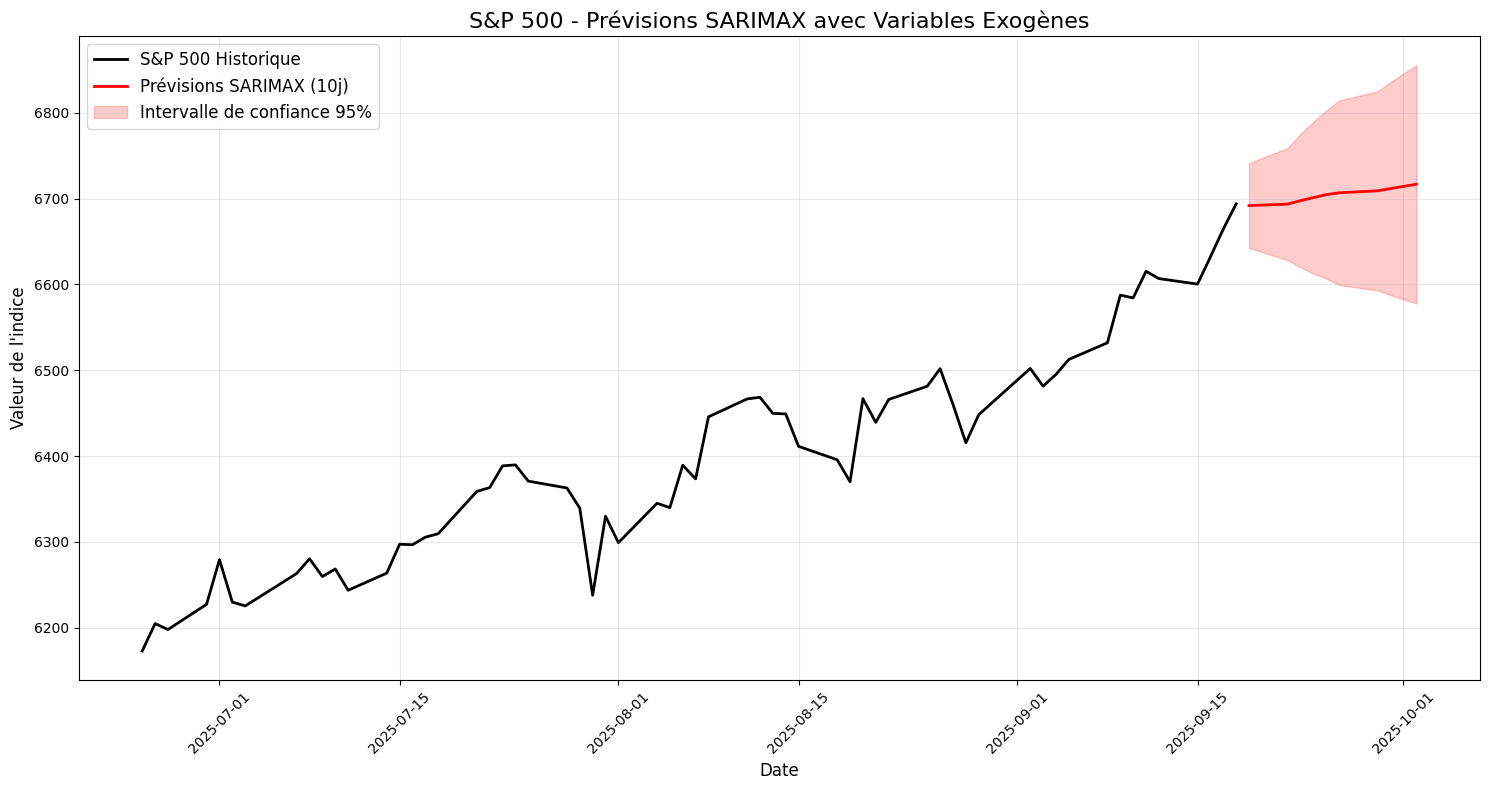

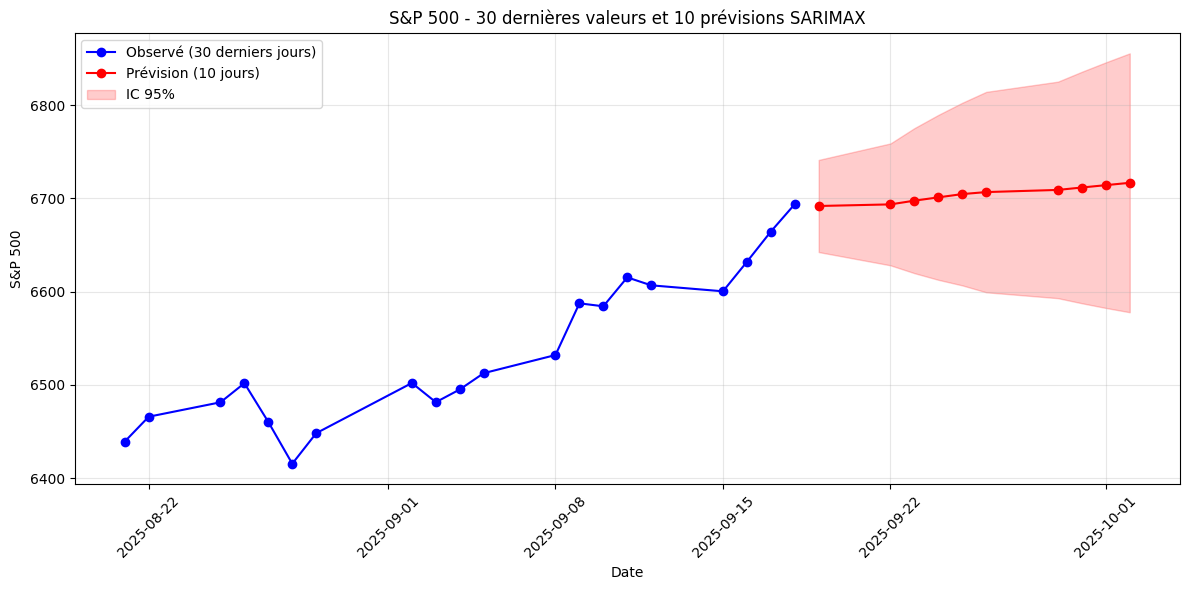


6. Résumé du modèle:
                                     SARIMAX Results                                     
Dep. Variable:                             cible   No. Observations:                 6719
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood              -31174.669
Date:                           Wed, 01 Oct 2025   AIC                          62471.338
Time:                                   16:02:11   BIC                          62886.839
Sample:                                        0   HQIC                         62614.817
                                          - 6719                                         
Covariance Type:                             opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
drift                        0.0003   3.93e-05      7.011      0.000    

In [119]:
class SP500SARIMAXForecaster:
    """
    Modèle SARIMAX pour S&P 500 avec variables exogènes
    """
    
    def __init__(self):
        self.model = None
        self.fitted_model = None
        self.data = None
        self.exog_vars = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_data(self, file_path):
        """
        Charge les données depuis le fichier Excel
        """
        try:
            # Lire le fichier Excel
            df = data
            
            # Détecter la colonne de date
            date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
                df.set_index(date_cols[0], inplace=True)
            else:
                print("Aucune colonne de date détectée. Veuillez spécifier manuellement.")
                
            self.data = df
            return df
            
        except Exception as e:
            print(f"Erreur lors du chargement: {e}")
            return None
    
    def create_market_features(self, target_column='cible'):
        """
        Crée des variables techniques et calendaires utiles pour le S&P 500
        
        Parameters:
        -----------
        target_column : str
            Nom de la colonne contenant les prix du S&P 500
        """
        if self.data is None:
            raise ValueError("Données non chargées. Utilisez load_data() d'abord.")
            
        df = self.data.copy()
        
        # === VARIABLES TECHNIQUES ===
        
        # 1. Rendements et volatilité
        if target_column in df.columns:
            df['returns'] = df[target_column].pct_change()
            df['log_returns'] = np.log(df[target_column] / df[target_column].shift(1))
            
            # Volatilité réalisée (rolling)
            df['volatility_5d'] = df['returns'].rolling(5).std()
            df['volatility_20d'] = df['returns'].rolling(20).std()
        
        # 2. Moyennes mobiles et signaux techniques
        if target_column in df.columns:
            df['mov_avg_10d'] = df['mov_avg_10d']
            df['mov_avg_20d'] = df['mov_avg_20d']
            df['mov_avg_30d'] = df['mov_avg_30d']
            df['mov_avg_50d'] = df['mov_avg_50d']
            df['mov_avg_100d'] = df['mov_avg_100d']
            df['mov_avg_200d'] = df['mov_avg_200d']
            
            # Signaux techniques
            df['ma_signal_short'] = (df[target_column] > df['mov_avg_10d']).astype(int)
            df['ma_signal_long'] = (df[target_column] > df['mov_avg_50d']).astype(int)
        
        # 3. Volume (si disponible)
        if 'volume' in df.columns:
            df['volume_ma_20'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma_20']
            df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
        
        # === VARIABLES MACRO-ÉCONOMIQUES (si disponibles) ===        
        
        self.data = df
        print(f"Variables créées. Nouvelles dimensions: {df.shape}")
        return df
    
    def select_exog_variables(self, target_column='cible', method='all'):
        """
        Sélectionne les meilleures variables exogènes
        
        Parameters:
        -----------
        target_column : str
            Variable cible (S&P 500)
        method : str
            'correlation', 'all', ou liste des noms de variables
        """
        if self.data is None:
            raise ValueError("Données non disponibles.")
            
        # Variables candidates (exclure la cible et variables avec trop de NaN)
        exclude_cols = [target_column, 'returns', 'log_returns'] + \
                      [col for col in self.data.columns if self.data[col].isna().sum() > len(self.data) * 0.1]
        
        candidate_vars = [col for col in self.data.columns if col not in exclude_cols and 
                         self.data[col].dtype in ['int64', 'float64', 'bool']]
        
        if method == 'all':
            selected_vars = candidate_vars
        elif method == 'correlation':
            # Sélection basée sur la corrélation avec les rendements
            if 'returns' in self.data.columns:
                correlations = self.data[candidate_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
                # Prendre les 15 variables les plus corrélées
                selected_vars = correlations.head(16).index.tolist()
                selected_vars.remove('returns') if 'returns' in selected_vars else None
            else:
                selected_vars = candidate_vars[:15]  # Limiter à 15 variables
        elif isinstance(method, list):
            selected_vars = [var for var in method if var in candidate_vars]
        else:
            selected_vars = candidate_vars[:10]
        
        # Préparer les données exogènes
        exog_data = self.data[selected_vars].fillna(method='ffill').fillna(0)
        self.exog_vars = exog_data
        self.feature_names = selected_vars
        
        print(f"Variables exogènes sélectionnées ({len(selected_vars)}):")
        for i, var in enumerate(selected_vars, 1):
            print(f"{i:2d}. {var}")
            
        # Montrer les corrélations si disponibles
        if 'returns' in self.data.columns:
            print(f"\nCorrélations avec les rendements:")
            corr_with_returns = self.data[selected_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
            for var in corr_with_returns.head(5).index:
                if var != 'returns':
                    print(f"   {var}: {corr_with_returns[var]:.3f}")
        
        return exog_data
    
    def fit_sarimax_model(self, target_column='close', 
                         order=(1,1,1), seasonal_order=(1,0,1,5)):
        """
        Ajuste le modèle SARIMAX avec variables exogènes
        """
        if self.data is None or self.exog_vars is None:
            raise ValueError("Données ou variables exogènes non préparées.")
            
        target_series = self.data[target_column].dropna()
        
        # Aligner les données exogènes avec la série cible
        common_index = target_series.index.intersection(self.exog_vars.index)
        target_aligned = target_series.loc[common_index]
        exog_aligned = self.exog_vars.loc[common_index]
        
        print(f"Ajustement SARIMAX{order}x{seasonal_order}")
        print(f"Données: {len(target_aligned)} observations")
        print(f"Variables exogènes: {len(self.feature_names)}")
        
        try:
            self.model = SARIMAX(
                target_aligned,
                exog=exog_aligned,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend='t'
            )
            
            self.fitted_model = self.model.fit(disp=False)
            self.is_fitted = True
            
            print(f"Modèle ajusté avec succès!")
            print(f"AIC: {self.fitted_model.aic:.2f}")
            print(f"Log-likelihood: {self.fitted_model.llf:.2f}")
            
            return self.fitted_model
            
        except Exception as e:
            print(f"Erreur lors de l'ajustement: {e}")
            return None
    
    def forecast_with_exog(self, n_periods=10, exog_forecast=None):
        """
        Génère des prévisions avec variables exogènes
        
        Parameters:
        -----------
        n_periods : int
            Nombre de périodes à prédire
        exog_forecast : DataFrame, optional
            Valeurs futures des variables exogènes
            Si None, utilise la dernière valeur observée
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        if exog_forecast is None:
            # Utiliser les dernières valeurs pour les variables exogènes
            last_exog = self.exog_vars.iloc[-1:].copy()
            exog_forecast = pd.concat([last_exog] * n_periods, ignore_index=True)
        
        try:
            forecast = self.fitted_model.forecast(steps=n_periods, exog=exog_forecast)
            conf_int = self.fitted_model.get_forecast(steps=n_periods, exog=exog_forecast).conf_int()
            
            return forecast, conf_int
            
        except Exception as e:
            print(f"Erreur lors de la prévision: {e}")
            return None, None
    
    def plot_forecast(self, target_column='cible', n_periods=10, figsize=(15, 8)):
        """
        Visualise les prévisions SARIMAX
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        forecast, conf_int = self.forecast_with_exog(n_periods)
        
        if forecast is None:
            return
            
        # Données récentes
        recent_data = self.data[target_column].dropna()[-60:]
        
        # Dates futures
        last_date = recent_data.index[-1]
        future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_periods)
        
        plt.figure(figsize=figsize)
        
        # Données historiques
        plt.plot(recent_data.index, recent_data, 
                label='S&P 500 Historique', color='black', linewidth=2)
        
        # Prévisions
        plt.plot(future_dates, forecast, 
                label=f'Prévisions SARIMAX ({n_periods}j)', 
                color='red', linewidth=2)
        
        # Intervalles de confiance
        plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                        color='red', alpha=0.2, label='Intervalle de confiance 95%')
        
        plt.title('S&P 500 - Prévisions SARIMAX avec Variables Exogènes', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Valeur de l\'indice', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return forecast, conf_int
    
    def feature_importance(self):
        """
        Analyse l'importance des variables exogènes
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Coefficients des variables exogènes
        params = self.fitted_model.params
        # Prendre tous les coefficients qui sont dans feature_names
        exog_params = params[params.index.isin(self.feature_names)]
        
        if len(exog_params) > 0:
            # Créer un DataFrame avec les coefficients
            importance_df = pd.DataFrame({
                'Variable': self.feature_names[:len(exog_params)],
                'Coefficient': exog_params.values,
                'Abs_Coefficient': np.abs(exog_params.values),
                'P_Value': self.fitted_model.pvalues[exog_params.index].values
            }).sort_values('Abs_Coefficient', ascending=False)
            
            print("=== IMPORTANCE DES VARIABLES EXOGÈNES ===")
            print(importance_df.head(10).to_string(index=False))
            
            # Graphique
            top_vars = importance_df.head(10)
            plt.figure(figsize=(12, 8))
            colors = ['red' if coef < 0 else 'green' for coef in top_vars['Coefficient']]
            plt.barh(range(len(top_vars)), top_vars['Coefficient'], color=colors)
            plt.yticks(range(len(top_vars)), top_vars['Variable'])
            plt.xlabel('Coefficient')
            plt.title('Top 10 Variables Exogènes - Impact sur S&P 500')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            print("exog_params:", exog_params)
            print("feature_names:", self.feature_names)
            print("exog_vars shape:", self.exog_vars.shape)
            
            return importance_df
        else:
            print("Aucune variable exogène détectée dans le modèle.")
            return None
    
    def summary(self):
        """Résumé du modèle"""
        if self.fitted_model:
            return self.fitted_model.summary()
        else:
            print("Modèle non ajusté.")


# Initialiser le forecaster
forecaster = SP500SARIMAXForecaster()
forecaster.data = data

# 1. Créer les variables techniques
print("1. Création des variables techniques...")
forecaster.create_market_features(target_column='cible')  # Remplacez 'cible' par votre colonne prix

# 2. Sélectionner les variables exogènes
exog_vars = forecaster.select_exog_variables(target_column='cible', method='all')

# 3. Ajuster le modèle SARIMAX
fitted_model = forecaster.fit_sarimax_model(
    target_column='cible',
    order=(1,1,1),
    seasonal_order=(1,0,1,5)
)

if fitted_model:
    # 4. Analyser l'importance des variables
    importance = forecaster.feature_importance()
    
    # 5. Générer des prévisions
    forecast, conf_int = forecaster.plot_forecast(target_column='cible', n_periods=10)
    
    # Extraire les 30 dernières valeurs observées
    last_30 = forecaster.data['cible'].dropna()[-20:]

    # Créer les dates futures (si pas déjà fait)
    last_date = last_30.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=len(forecast))

    # Concaténer les valeurs et les dates pour un seul plot si besoin
    all_values = pd.concat([last_30, pd.Series(forecast.values, index=future_dates)])
    all_dates = all_values.index

    plt.figure(figsize=(12, 6))
    plt.plot(last_30.index, last_30.values, label='Observé (30 derniers jours)', color='blue', marker='o')
    plt.plot(future_dates, forecast.values, label='Prévision (10 jours)', color='red', marker='o')
    plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='IC 95%')
    plt.title("S&P 500 - 30 dernières valeurs et 10 prévisions SARIMAX")
    plt.xlabel("Date")
    plt.ylabel("S&P 500")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ...existing code...
    
    # 6. Résumé du modèle
    print("\n6. Résumé du modèle:")
    print(forecaster.summary())

    # 7. AFFICHER LES PRÉDICTIONS FUTURES
    print("\n7. PRÉDICTIONS FUTURES")
    print("=" * 60)

    # Récupérer les prédictions
    forecast, conf_int = forecaster.forecast_with_exog(n_periods=10)

    # Créer les dates futures
    last_date = forecaster.data.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=10)

    # Afficher les prédictions
    print(f"\nDernière valeur observée: {forecaster.data['cible'].iloc[-1]:.2f}")
    print(f"Date: {last_date.strftime('%Y-%m-%d')}\n")

    print("Prédictions pour les 10 prochains jours:")
    print("-" * 60)
    for i in range(len(forecast)):
        date = future_dates[i]
        price = forecast.iloc[i]
        lower = conf_int.iloc[i, 0]
        upper = conf_int.iloc[i, 1]
        
        print(f"{date.strftime('%Y-%m-%d')} | Prix: {price:7.2f} | IC 95%: [{lower:7.2f}, {upper:7.2f}]")

    # Variation attendue J+1
    change = forecast.iloc[0] - forecaster.data['cible'].iloc[-1]
    change_pct = (change / forecaster.data['cible'].iloc[-1]) * 100

    print("\n" + "=" * 60)
    print(f"💡 PRÉDICTION POUR DEMAIN:")
    print(f"   Prix prédit: {forecast.iloc[0]:.2f}")
    print(f"   Variation:   {change:+.2f} ({change_pct:+.2f}%)")
    print("=" * 60)
